"I/we certify that the code and data in this assignment were generated independently, using only the tools and resources defined in the course and that I/we did not receive any external help, coaching or contributions during the production of this work."

In [1]:
!pip install Box2D

     |████████████████████████████████| 1.3 MB 5.3 MB/s 


Implementing Double DQN on LunarLander environment

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces

In [3]:
import tensorflow as tf
import random, math, time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import matplotlib
import tensorflow.keras.backend as K

In [4]:

lunar_env = gym.make('LunarLander-v2')
lunar_env.reset()
print(lunar_env.action_space.n)
print(lunar_env.observation_space)
print(lunar_env.observation_space.high)
print(lunar_env.observation_space.low)


4
Box(-inf, inf, (8,), float32)
[inf inf inf inf inf inf inf inf]
[-inf -inf -inf -inf -inf -inf -inf -inf]


This environment has the following properties:
1.   Reward Solved is 200 points
2.   Four discrete actions possible

In [5]:
class ReplayBuffer(object):

    def __init__(self, size):
      self.size = size
      self.buffer = []
      self.idx = 0

    def add(self,state,action,reward,newstate,done):
      if len(self.buffer) >= self.size:
        self.buffer[self.idx] = (state,action,reward,newstate,done)
      else:
          self.buffer.append((state,action,reward,newstate,done))

      self.idx+=1

      if self.idx == self.size:
        self.idx = 0

    def sample(self, batch_size):
      size_sample = min(len(self.buffer), batch_size)
      return random.sample(self.buffer, size_sample)
      

In [6]:
class Agent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, observation):
    return np.random.choice(self.action_space.n)

Below is the application of Double DQN on lunar lander

In [7]:
class DDQLearning:
    def __init__(self,env,agent):
        self.env = env
        self.agent = agent
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.DDepsilon_decay = []
        self.ddqn_reward_train = []
        self.DDlosses = []
        
    def greedy_act_max(self,obs):
        return np.argmax(self.model_target(obs))
        
    def policy(self,epsilon,obs):
        return random.choices([np.random.randint(self.action_space.n), self.greedy_act_max(obs)], weights =(epsilon,1-epsilon),k=1)[0]
    
    def max_Qval(self,state):
        return np.argmax(self.target_qtable, axis=1)[state]

    def learning_network_model(self,lr,input_state_dim,output_action_dim):
        model = Sequential()
        model.add(Dense(32, input_dim=input_state_dim, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(output_action_dim, activation='linear'))
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(loss='mse', optimizer=opt)
        return model
        
    def train(self,episodes,gamma,alfa_lr,decay_factor,replay_buffer_size=2000,minibatch_size=128):
        epsilon = 1
        episodes = episodes
        rbuffer = ReplayBuffer(replay_buffer_size)
        obs = self.env.reset()
        obs_size = 8
        action_size = self.env.action_space.n
        self.model_policy = self.learning_network_model(alfa_lr,obs_size,action_size)
        self.model_target = self.learning_network_model(alfa_lr,obs_size,action_size)
        self.model_target.set_weights(self.model_policy.get_weights())
        overall_step = 0
        for eps_n in np.arange(episodes):
            obs = self.env.reset()
            done_iter = False
            self.DDepsilon_decay.append(epsilon)
            #print("The episode no. is " + str(eps_n))
            cumm_reward=0
            step_no=0

            while not done_iter:
              agent_pnow = np.argmax(obs)
              action = int(self.policy(epsilon,obs.reshape(1,obs_size)))
              obs_next, reward, done_iter, info = self.env.step(action)
              cumm_reward += (gamma**(step_no))*reward

              rbuffer.add(obs.reshape(1,obs_size),action,reward,obs_next.reshape(1,obs_size), done_iter)
              step_no+=1
              overall_step += 1
              obs = obs_next
              
              batch = rbuffer.sample(minibatch_size)
              batch_size = len(batch)
              if batch_size == minibatch_size:
                curr_pos_batch = np.array([ sample_state[0] for sample_state in batch ])
                if step_no%5==0:
                  state_next = tf.stack([s2 for (s1,a,r,s2,d) in batch])
                  curr_state = tf.stack([s1 for (s1,a,r,s2,d) in batch])
                  action_ = tf.stack([a for (s1,a,r,s2,d) in batch])
                  reward_ = tf.cast(tf.stack([r for (s1,a,r,s2,d) in batch]), tf.float32)
                  done_ = tf.cast(tf.stack([d for (s1,a,r,s2,d) in batch]), tf.float32)
                  if True:
                    next_q = self.model_policy.predict(tf.reshape(state_next,(minibatch_size,obs_size)))
                    #print("7")
                    max_a = tf.math.argmax(next_q, 1)
                    #print("8")
                    double_q = self.model_target.predict(tf.reshape(state_next,(minibatch_size,obs_size)))
                    #print("9")
                    target_y = reward_  + gamma*(1-done_)*(tf.gather(double_q[0], max_a).numpy())
                    #print("10")
 
                  #print("11")
                  #print("12")
                  x = tf.reshape(curr_state,(minibatch_size,obs_size))
                  #print("13")
                  q_predicted = self.model_policy.predict(tf.reshape(curr_state,(minibatch_size,obs_size)))
                  dept_action = tf.expand_dims(action_, 1)    #adding depth dimension to the action tensor
                  #print("14", b_2)
                  index_tensor = tf.expand_dims(tf.range(tf.shape(action_)[0]), 1)   #adding depth dimension to a new tensor with shape as action tensor
                  #print("15", range)
                  index_to_update = tf.concat([index_tensor, dept_action], 1)        #adding depth dimension to a new tensor with shape as action tensor
                  #print("16")
                  y = tf.tensor_scatter_nd_update(q_predicted, index_to_update, target_y)
                  #print("14")
                  #print(tf.shape(x) ,tf.shape(y))
                  sequential_model = self.model_policy.fit(x, y, batch_size=minibatch_size, epochs=1, verbose=0)
                  self.DDlosses.append(sequential_model.history['loss'])
                  #print("16")
                  if overall_step%400 ==0:
                    self.model_target.set_weights(self.model_policy.get_weights())

            if epsilon > 0.001 : epsilon = epsilon*decay_factor
            self.ddqn_reward_train.append(cumm_reward)
            print("cummulative reward is " + str(cumm_reward) + " for episode no. " + str(eps_n + 1)  )  
            
            

In [8]:
agent = Agent(lunar_env)

epsilon = 1
number_of_episodes = 1000
decay_factor = round((0.01/epsilon)**(1/number_of_episodes),4)

ddql = DDQLearning(lunar_env,agent)

In [9]:
ddql.train(episodes = number_of_episodes,gamma = 0.99, alfa_lr = 0.001, decay_factor=decay_factor)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 8ms/step - loss: 16.4486
cummulative reward is -19.946917447413618 for episode no. 582
The episode no. is 582
1/1 [==============================] - 0s 10ms/step - loss: 1.2691
cummulative reward is 6.48348148645243 for episode no. 583
The episode no. is 583
1/1 [==============================] - 0s 5ms/step - loss: 0.9110
cummulative reward is -18.15240659937573 for episode no. 584
The episode no. is 584
1/1 [==============================] - 0s 9ms/step - loss: 4.1120
cummulative reward is -31.396309560661706 for episode no. 585
The episode no. is 585
1/1 [==============================] - 0s 5ms/step - loss: 0.8699
cummulative reward is -13.70219088855424 for episode no. 586
The episode no. is 586
1/1 [==============================] - 0s 5ms/step - loss: 3.8103
cummulative reward is -24.15762829257464 for episode no. 587
The episode no. is 587
1/1 [==============================] - 0s 6ms/s

KeyboardInterrupt: ignored

We had to abrupty terminate the training at around 658 steps due to insufficient time, so our epsilon decay is midway. But we see the rewards increasing smoothly as the model learns.

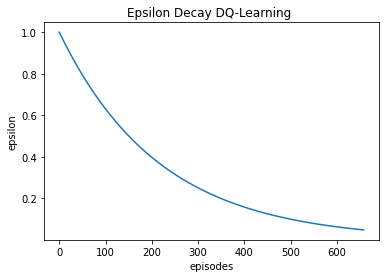

In [13]:
#Plotting Epsilon Decay DQ-Learning 
plt.plot(ddql.DDepsilon_decay,mfc='pink') 
plt.xticks(range(0,len(ddql.DDepsilon_decay)+1, 100)) 

plt.ylabel('epsilon')
plt.xlabel('episodes') 
plt.title("Epsilon Decay DQ-Learning ") 
plt.show()

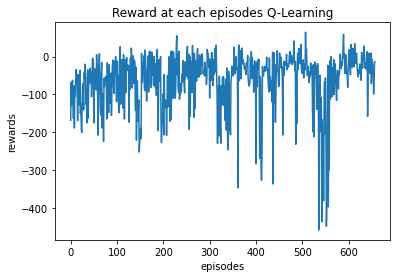

In [14]:
#Reward at each iteration DQ-Learning
plt.plot(ddql.ddqn_reward_train) 
plt.xticks(range(0,len(ddql.ddqn_reward_train)+1, 100)) 

plt.ylabel('rewards')
plt.xlabel('episodes') 
plt.title("Reward at each episodes Q-Learning") 
plt.show()

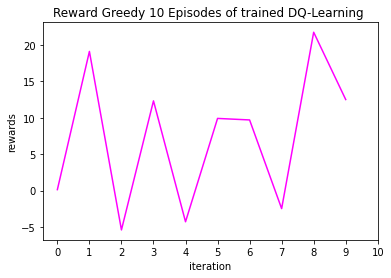

In [16]:
#evaluate Q learning
gamma = 0.95

reward_DQlearning_10ep = []
for i in np.arange(10):
    obs = ddql.env.reset()
    done_iter = False
    print(i,end="\r")
    cumm_reward=0
    step_no = 0
    while not done_iter:
        action = int(ddql.greedy_act_max(obs.reshape(1,8)))
        obs_next, reward, done_iter, info = ddql.env.step(action)
        cumm_reward += (gamma**(step_no))*reward
        obs = obs_next
        # done_iter = done
        step_no += 1
    reward_DQlearning_10ep.append(cumm_reward)

plt.plot(reward_DQlearning_10ep,color='magenta') 
plt.xticks(range(0,len(reward_DQlearning_10ep)+1, 1)) 

plt.ylabel('rewards')
plt.xlabel('iteration') 
plt.title("Reward Greedy 10 Episodes of trained DQ-Learning ") 
plt.show()